# 轨迹推断

对于连续变化的表型状态，使用分簇的方法鉴定差异基因存在主观性，并且不能确定的给出分群的依据，因为大部分基因表达都是动态变化的。
这种情形在连续性的细胞表型转变过程（发育过程、极化、缓慢的重编程等）是常见的。轨迹推断方法使用一条人为给定的 kNN 图路径，
并将细胞分配到路径的不同位置，可以根据这些位置信息量化基因变化的形式

轨迹推断完全基于 kNN 图，如果 kNN 图不合适，轨迹就是错误的。一般而言，UMAP 比 tSNE 更加考虑到局部拓扑结构的信息，而在一些
情况下 Diffusion Map 比 UMAP 更加合适（但是并不绝对），你需要选择一种在你的数据集中可以合适反映表型拓扑结构的降维方法，而且确保自己的
数据确实捕捉到了中介细胞群。有时，过强的拓扑结构捕获能力会引入人为的虚假路径。理想情况下，你应该现在你的降维图中观察到生物学相关的
细胞出现相连的图，而无关的细胞单独成群。有时，你的数据因为缺漏太多或其他原因，无论如何修改降维算法参数都不能观察到合理的路径，
这种情况不适合进行轨迹推断

轨迹推断的起点和终点表型是完全由操作者决定的，需要操作者的先验知识。在缺乏实验证明的先验知识时，这些轨迹的防线有可能（而且很大）是错误的。
RNA 速率、转录因子熵 的一些计算方法声称自己可以推断一个轨迹，但他们的结果并没有得到广泛的正确性的验证

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import exprmat as em
em.setwd('/home/data/yangz/bioinfo/geo/m-bone-marrow-metastasis')
ver = em.version()

[i] exprmat 0.1.45 / exprmat-db 0.1.45
[i] os: posix (linux)  platform version: 5.15.0-139-generic
[i] loaded configuration from /home/data/yangz/.exprmatrc
[i] current working directory: /home/data/yangz/bioinfo/geo/m-bone-marrow-metastasis
[i] current database directory: /home/data/yangz/bioinfo/packages/database (0.1.45)
[i] resident memory: 809.31 MiB
[i] virtual memory: 5.71 GiB


In [4]:
expm = em.load_experiment('expm', load_samples = False)

[!] samples are not dumped in the experiment directory.


In [6]:
print(expm)

annotated data of size 14626 × 20349
integrated dataset of size 14626 × 20349
contains modalities: rna

 modality [rna]
    obs : sample <cat> batch <cat> group <cat> modality <cat> taxa <cat> barcode <o> ubc <o>
          n.umi <f64> n.genes <i64> n.mito <f64> n.ribo <f64> pct.mito <f64> pct.ribo <f64>
          filter <bool> score.doublet <f64> score.doublet.se <f64> is.doublet <bool> qc <bool>
          leiden <cat>
    var : chr <cat> start <i64> end <i64> strand <cat> id <o> subtype <cat> gene <cat> tlen <f64>
          cdslen <i64> assembly <cat> uid <o> vst.hvg <bool> vst.all.means <f64> vst.all.vars <f64>
          vst.all.vars.norm <f64> vst.all.hvg.rank <f32> vst.all.hvg <bool>
 layers : counts <f32>
   obsm : harmony <arr:f64(50)> knn.d.nn100 <arr:f32(100)> knn.nn100 <arr:i32(100)>
          pca <arr:f64(50)> umap <arr:f32(2)>
   varm : pca <arr:f64(50)>
   obsp : connectivities.nn100 <csr:f32> distances.nn100 <csr:f32>
    uns : leiden leiden.colors nn100 pca umap

[*] comp

### Diffmap 降维

Diffmap 在一些情况下可能比 UMAP 更加敏感的获取拓扑结构信息

In [28]:
expm.run_rna_diffmap(
    neighbors_key = 'nn100', key_added = 'diffmap', 
    n_comps = 5, sort = 'decrease', density_normalize = True,
    use_gpu = True
)

In [36]:
expm.run_rna_knn(
    use_rep = 'diffmap',
    n_comps = None,
    n_neighbors = 30,
    knn = True,
    method = "umap",
    transformer = None,
    metric = "euclidean",
    metric_kwds = {},
    random_state = 42,
    key_added = 'nn30.diffmap',
    use_gpu = True
)

在我们的数据集中，他和 UMAP 表现相当，我们仍然以二维 UMAP 降维进行轨迹推断

In [39]:
expm.run_rna_umap(
    min_dist = 0.30,
    spread = 0.6,
    n_components = 2,
    maxiter = None,
    alpha = 1,
    gamma = 1,
    negative_sample_rate = 5,
    init_pos = "spectral",
    random_state = 78,
    a = None,
    b = None,
    key_added = 'umap.diff',
    neighbors_key = "nn30.diffmap"
)

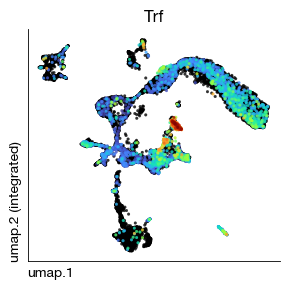

In [66]:
fig = expm.plot_rna_embedding(
    basis = 'umap', color = 'Trf', annotate_style = 'text', legend = False,
    figsize = (3, 3), dpi = 100, ptsize = 4, contour_plot = False
)

### 主曲线推断

接下来，我们使用无监督方法从数据集的结构中推断可能的轨迹

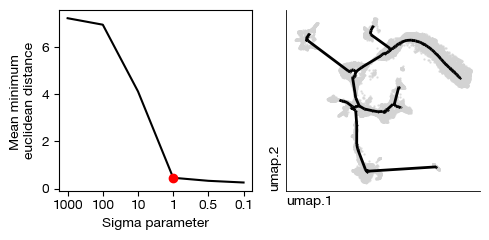

In [8]:
expm.run_rna_principle_tree_explore_sigma(
    nodes = 200,
    use_rep = 'umap',
    ndims_rep = None,
    sigmas = [1000, 100, 10, 1, 0.5, 0.1],
    nsteps = 1,
    metric = "euclidean",
    seed = None,
    key_added = 'ppt'
)

In [9]:
expm.run_rna_principle_tree(
    use_rep = 'umap',
    method = "ppt",
    init = None,
    ppt_sigma = 0.6, # test that
    ppt_lambda = 1,
    ppt_metric = "euclidean",
    ppt_nsteps = 50,
    ppt_err_cut = 5e-3,
    ppt_gpu_tpb = 16,
    device = "gpu",
    seed = 42,
    key_added = 'ppt',
)

分岔点和终节点是轨迹中重要的关键阶段，你可以查看他们的编号，并考虑给他们一个人类可读的名字

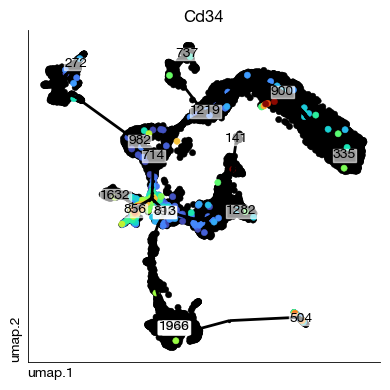

In [103]:
fig = expm.plot_rna_graph(
    basis = 'umap',
    tips = True,
    forks = False,
    nodes = [900],
    rasterized = True,
    ax = None,
    trajectory_key = 'ppt',
    background_color = 'Cd34',
    legend = False,
    annotate = False,
    ptsize = 20, alpha = 1,
    figsize = (4, 4),
    size_nodes = 2,
    cmap = 'turbo', default_color = 'lightgray'
)

### 确定轨迹的方向

得到的树状轨迹是没有方向的，也就是说，计算机在这一步并不知道干细胞和终末分化的细胞分别在图的那个节点上。
你需要指定起点，算法会自动识别终点。在后续操作中，你也可以手动指定起点和终点计算基因表达模式

In [11]:
expm.run_rna_principle_tree_root(trajectory_key = 'ppt', root = 856)

[i] node 856 selected as a root


In [12]:
expm.run_rna_principle_tree_pseudotime(
    trajectory_key = 'ppt',
    seed = 42,
    cmap = 'category20b'
)

[i] projecting cells onto the principal graph


   ━━━━━━━━━━━━━━━━━━━━━━━━━━ mapping               2000 / 2000  (00:07 < 00:00)


In [13]:
expm['rna'].obs[['ppt.pseudotime', 'ppt.seg', 'ppt.edge', 'ppt.milestones']]

,ppt.pseudotime,ppt.seg,ppt.edge,ppt.milestones
normal:1,19.572771,9,611|1038,335
normal:2,19.148009,9,1715|1562,335
normal:3,20.082688,9,321|42,335
normal:4,23.036064,9,443|429,335
normal:5,16.623985,9,573|574,197
...,...,...,...,...
niche:3955,20.719992,23,504|27,504
niche:3956,5.633197,18,519|1036,1773
niche:3957,23.922432,9,335|1154,335
niche:3958,4.177065,18,1155|1527,400


计算机会根据指定的起点计算拟时间，无论它的方向是否正确，只要有计算的顺序，你可以在后面手动确认路径时按需要反转

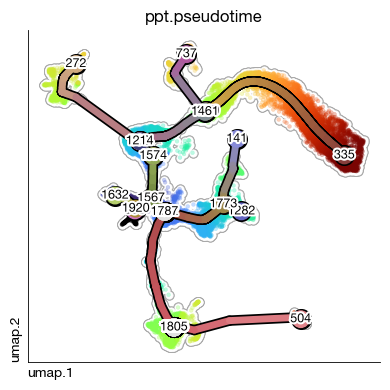

In [14]:
fig = expm.plot_rna_principle_tree_segments(
    # trajectory plot
    basis = 'umap',
    color_seg = "milestones",
    trajectory_key = 'ppt',
    embedding_dims = [0, 1],
    annotate = True,
    
    # basis plot
    background_color = 'ppt.pseudotime', cmap = 'turbo', figsize = (4, 4),
    legend = False, default_color = 'lightgray',
    add_outline = True, outline_color = 'darkgray', alpha = 0.3, sort = True
)

你可以给一些关键的节点命名，这将会反映在图上

In [ ]:
expm.run_rna_principle_tree_rename_milestones(
    trajectory_key = 'ppt',
    rename = {
        856: 'HSC',
        335: 'Neu',
        1920: '',
        1632: 'pDC',
        1805: '', 1710: '', 1481: '', 1251: '', 1233: '', 1228: '', 1021: '', 800: '', 524: '',
        473: '', 415: '', 312: '', 25: '', 1949: '', 1478: '', 1437: '', 1249: '', 1109: '', 968: '',
        779: '', 703: '', 695: '', 411: '', 298: '', 124: '', 1966: '',
        272: 'T',
        737: 'Ery',
        504: 'Ba',
        1773: 'Mac',
        141: 'Mac.e',
        1282: '', 1219: '', 1461: '', 1214: '', 1574: '', 663: '', 197: '', 982: '', 714: '',
        1567: '', 1787: '', 1432: '', 400: '', 165: '', 813: '', 492: '', 115: '',
    }
)

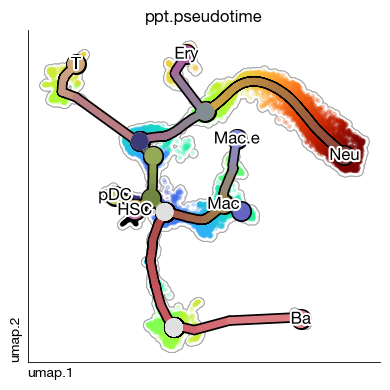

In [218]:
fig = expm.plot_rna_principle_tree_segments(
    # trajectory plot
    basis = 'umap',
    color_seg = "milestones",
    trajectory_key = 'ppt',
    embedding_dims = [0, 1],
    annotate = True,
    annotate_fontsize = 12,
    
    # basis plot
    background_color = 'ppt.pseudotime', cmap = 'turbo', figsize = (4, 4),
    legend = False, default_color = 'lightgray',
    add_outline = True, outline_color = 'darkgray', alpha = 0.3, sort = True
)

In [266]:
expm.save(save_samples = False)

[i] main dataset write to expm/integrated.h5mu


### 追踪基因表达模式

针对一条你感兴趣的路径，你可以发现那些基因沿着这条路径显著性变化，并揭示他们的变化模式

这一步是细胞基因表达量对拟时间（正序或者倒序，取决于你指定的起点和终点）的回归过程，如果他不是对拟时间的常量，这个基因就会被识别出来。
为了使得回归过程更加稳定，我们推荐对稀疏的表达量矩阵进行补全，MAGIC 方法是一个推荐的基于图扩散的补全算法。他在小于 50k 细胞的
数据集上可以较为优雅的运行。然而，似乎他的耗时会随细胞数目非线性的增加

In [6]:
expm.run_rna_impute_magic(
    key_added = 'magic', solver = 'approximate', t = 'auto', 
    random_state = 42, n_jobs = 60, n_pca = 30, knn = 15
)

[i] running MAGIC on 14626 cells and 20349 genes.
Calculating PCA...
Calculated PCA in 5.98 seconds.
Calculating KNN search...
Calculated KNN search in 2.66 seconds.
Calculating affinities...
Calculated affinities in 2.66 seconds.
[i] automatically selected t = 5


可以看到，基因的表达量被平滑了

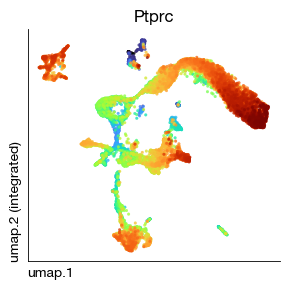

In [25]:
fig = expm.plot_rna_embedding(
    basis = 'umap', color = 'Ptprc', annotate_style = 'text', legend = False,
    figsize = (3, 3), dpi = 100, ptsize = 4, contour_plot = False, slot = 'magic'
)

指定 `source` 和 `destination` 的节点序号，程序会自动在路径图中查找到这两个节点之间的最短路径
例如节点 `335` 是成熟的中性粒细胞，而 `source` 缺失代表以先前指定的 root 节点作为起始

In [ ]:
expm.run_rna_principle_tree_trace(
    destination = 335, source = None, 
    trajectory_key = 'ppt', 
    lognorm = 'magic', 
    binning = 15, 
    statistic = 'mean',
    skip_sparsity = 40,
    order = 3, 
    key_added = 'trace'
)

[!] there exists several shortest paths. returing a random one.


   ━━━━━━━━━━━━━━━━━━━━━━━━━━ regressing genes: 36 20349 / 20349 (00:31 < 00:00)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━ regressing genes: 48 20349 / 20349 (00:30 < 00:00)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━ regressing genes: 47 20349 / 20349 (00:30 < 00:00)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━ regressing genes: 41 20349 / 20349 (00:30 < 00:00)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━ regressing genes: 29 20349 / 20349 (00:30 < 00:00)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━ regressing genes: 9  20349 / 20349 (00:31 < 00:00)


In [14]:
expm.run_rna_principle_tree_trace(
    destination = 1773, source = None, 
    trajectory_key = 'ppt', 
    lognorm = 'magic', 
    binning = 50, 
    statistic = 'mean',
    skip_sparsity = 40,
    order = 3, 
    key_added = 'trace.mac'
)

[!] there exists several shortest paths. returing a random one.


   ━━━━━━━━━━━━━━━━━━━━━━━━━━ regressing genes: 36 20349 / 20349 (00:30 < 00:00)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━ regressing genes: 48 20349 / 20349 (00:30 < 00:00)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━ regressing genes: 7  20349 / 20349 (00:30 < 00:00)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━ regressing genes: 18 20349 / 20349 (00:30 < 00:00)


In [15]:
expm['rna'].uns['trace.mac'].obs[['chr', 'gene', 'leiden', 'p']]

,chr,gene,leiden,p
rna:mmu:g24605,chr17,Zfp52,18,8.346270e-24
rna:mmu:g5831,chr10,2610008E11Rik,18,1.064873e-18
rna:mmu:g49410,chr6,Gsg1,18,7.575706e-12
rna:mmu:g24581,chr17,Zfp160,18,2.705111e-22
rna:mmu:g45774,chr5,Zfp157,18,1.141546e-21
...,...,...,...,...
rna:mmu:g24374,chr17,Airn,9,9.059252e-14
rna:mmu:g55442,chr8,Mtmr7,9,3.680657e-26
rna:mmu:g42394,chr5,Ptpn12,9,2.596842e-15
rna:mmu:g24177,chr17,Ldhal6b,9,4.323650e-18


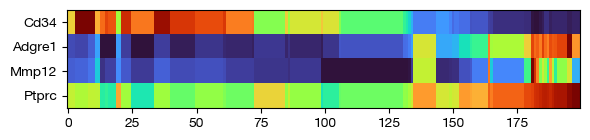

In [16]:
fig = expm.plot_rna_principle_tree_trace(
    trace_key = 'trace.mac',
    trajectory_key = 'ppt',
    values = 'expression',
    show_hvg_only = None,
    show_leiden_only = None,
    show_genes = ['Cd34', 'Ptprc', 'Adgre1', 'Mmp12'],
    p_cutoff = 0.0001,
    cmap = 'turbo',
    figsize = (6, 1.5),
    show_gene_names = True
)

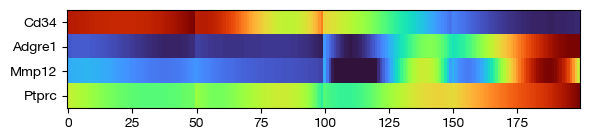

In [17]:
fig = expm.plot_rna_principle_tree_trace(
    trace_key = 'trace.mac',
    trajectory_key = 'ppt',
    values = 'fitted',
    show_hvg_only = None,
    show_leiden_only = None,
    show_genes = ['Cd34', 'Ptprc', 'Adgre1', 'Mmp12'],
    p_cutoff = 0.0001,
    cmap = 'turbo',
    figsize = (6, 1.5),
    show_gene_names = True
)

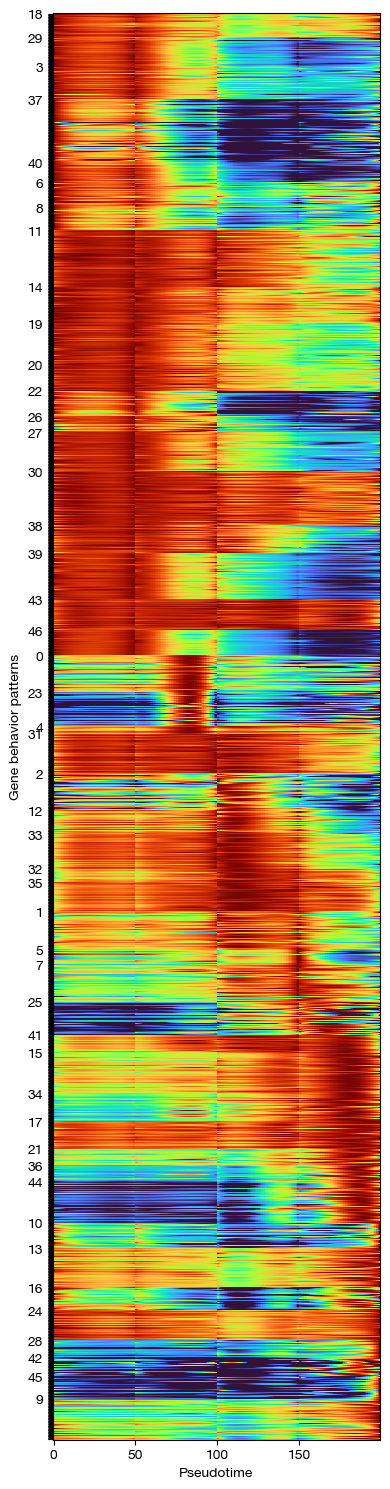

In [20]:
fig = expm.plot_rna_principle_tree_trace(
    trace_key = 'trace.mac',
    trajectory_key = 'ppt',
    values = 'fitted',
    show_hvg_only = 'vst.hvg',
    show_leiden_only = None,
    p_cutoff = 0.0001,
    cmap = 'turbo',
    figsize = (4, 15),
    show_gene_names = False
)

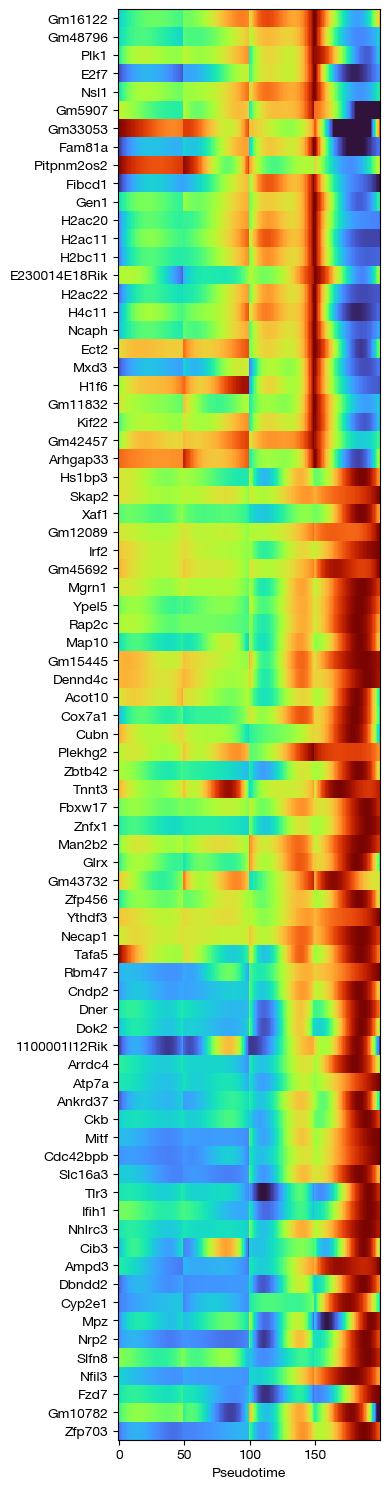

In [24]:
fig = expm.plot_rna_principle_tree_trace(
    trace_key = 'trace.mac',
    trajectory_key = 'ppt',
    values = 'fitted',
    show_hvg_only = 'vst.hvg',
    show_leiden_only = [5, 21, 36],
    p_cutoff = 0.0001,
    cmap = 'turbo',
    figsize = (4, 15),
    show_gene_names = True
)

In [25]:
expm.save()

[i] main dataset write to expm/integrated.h5mu
[i] saving individual samples. (pass `save_samples = False` to skip)
